In [157]:
import pickle
import os, sys
from astropy import units as u, constants as c
import numpy as np
from matplotlib import pyplot as plt
import emcee, tqdm
from scipy.special import erf
import corner

FIT_MORE = True
filename = "simstack2.pkl"

In [158]:
with open(filename, "rb") as f:
    results = pickle.load(f)
rkeys = list(results.keys())
bkeys = list(results['seds'].keys())
rkeys, results['wvs'], len(bkeys), bkeys[0]

(['wvs',
  'seds',
  'stds',
  'ngals',
  'z_med',
  'boot',
  'cov',
  'm_med',
  'nd',
  'beams'],
 [24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0],
 72,
 'z=0.01_0.33__logM=3_8__SF?=0')

In [159]:
if "nd" not in rkeys:
    results['nd'] = {}
    for bkey in bkeys:
        y = results['seds'][bkey]
        yerr_diag = np.diag(results['cov'][bkey])
        results['nd'][bkey] = (y - np.sqrt(yerr_diag)) < 0 
        # wavs for which the data is below the 1-sigma error
    with open(filename, "wb") as f:
        pickle.dump(results, f)
        
if "beams" not in rkeys:
    results['beams'] = np.array([1.55, 2.03, 4.66, 9.94, 17.65, 37.30, 5.68]) * 1e-9
    # values from the Viero+22 paper 2203.14312, Viero+13 paper 1304.0446, and 
    # SCUBA beam from https://academic.oup.com/mnras/article/465/2/1789/2454739
    with open(filename, "wb") as f:
        pickle.dump(results, f)

In [161]:
def black(nu_in, T):
    # h = 6.623e-34     ; Joule*s
    # k = 1.38e-23      ; Joule/K
    # c = 3e8           ; m/s
    # (2*h*nu_in^3/c^2)*(1/( exp(h*nu_in/k*T) - 1 )) * 10^29

    a0 = 1.4718e-21  # 2*h*10^29/c^2
    a1 = 4.7993e-11  # h/k

    num = a0 * nu_in ** 3.0
    den = np.exp(a1 * np.outer(1.0 / T, nu_in)) - 1.0
    ret = num / den

    return ret

def graybody_fn(theta, x): #=2.0, =1.8):
    if FIT_MORE:
        A, T, alphain, betain = theta
    else:
        A, T = theta
        alphain = 2.0
        betain = 1.8

    c_light = 299792458.0  # m/s

    nu_in = np.array([c_light * 1.e6 / wv for wv in x])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

if FIT_MORE:
    print(graybody_fn((35, 30, 2.0, 1.8), results['wvs'])[0])
else:
    print(graybody_fn((35, 30), results['wvs'])[0])

[7.849749348802555e+67 9.491263797299263e+68 6.269838296032081e+68
 2.4115712517811536e+68 9.489396082112747e+67 3.1247471874483694e+67
 5.195790115816918e+66]


z=0.01_0.33__logM=8_9__SF?=1


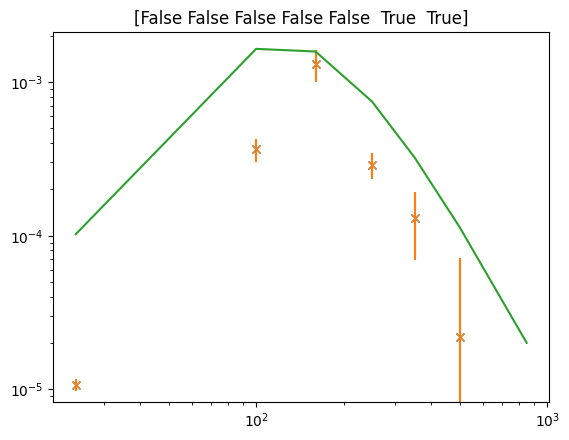

In [162]:
index = 3
key_to_plot = bkeys[index]
print(key_to_plot)
plt.figure()
plt.title(results['nd'][key_to_plot])
plt.errorbar(results['wvs'], results['seds'][key_to_plot], yerr=results['stds'][key_to_plot], fmt='x')
plt.errorbar(results['wvs'], results['seds'][key_to_plot], yerr=np.sqrt(np.diag(results['cov'][key_to_plot])), fmt='x')

if FIT_MORE:
    plt.plot(results['wvs'], graybody_fn((-36.3, 24.6, 2.0, 1.8), results['wvs'])[0])
else:
    plt.plot(results['wvs'], graybody_fn((-36.3, 24.6), results['wvs'])[0])

plt.loglog()
plt.show()
plt.close()

emcee time

In [163]:
def log_prior(theta, Amin=-38, Amax=-33, Tmin=5, Tmax=32, alpmin=1.0, alpmax=3.0, betmin=1.0, betmax=3.0):
    if FIT_MORE:
        A, T, alp, bet = theta
    else:
        A, T = theta
        alp = 2.0
        bet = 1.8
    if Amin < A < Amax and Tmin < T < Tmax and alpmin < alp < alpmax and betmin < bet < betmax:
        return 0.0
    return -np.inf

def log_prior_informative(theta, theta0, Amin=-38, Amax=-33, Tmin=5, Tmax=32, error_infl=1.0, \
                          alpmin=1.0, alpmax=3.0, betmin=1.0, betmax=3.0):
    if FIT_MORE:
        A, T, alp, bet = theta
    else:
        A, T = theta
        alp = 2.0
        bet = 1.8
    if FIT_MORE:
        A0, T0, sigma_T, alp0, bet0 = theta0
    else:
        A0, T0, sigma_T = theta0
        alp0 = 2.0
        bet0 = 1.8
    if Amin < A < Amax and Tmin < T < Tmax and sigma_T is not None and alpmin < alp < alpmax and betmin < bet < betmax:
        lp = -0.5 * (np.sum((T - T0) ** 2 / (sigma_T * error_infl) ** 2)) + \
                np.log(1.0 / (np.sqrt(2 * np.pi) * (sigma_T * error_infl) ** 2))
        return lp
    return -np.inf

def log_likelihood(theta, x, y, yerr, nd, sig_upp_lim=3.0):
    x_d, y_d, x_nd, y_nd = x[~nd], y[~nd], x[nd], y[nd] # 1d arrays
    for i in np.where(nd)[::-1]:
        yerr_d = np.delete(yerr, i, axis=0)
        yerr_d = np.delete(yerr_d, i, axis=1)
    nd_ulim = np.diag(yerr)[nd] # upper limit
    
    model_d = graybody_fn(theta, x_d)[0]
    dy = y_d - model_d
    ll_d = -.5 * (np.matmul(dy, np.matmul(np.linalg.inv(yerr_d), dy)) \
        + len(dy) * np.log(2 * np.pi)
        + np.log(np.linalg.det(yerr_d))
        )
    
    model_nd = graybody_fn(theta, x_nd)[0]
    ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
        erf((np.sqrt(nd_ulim) * sig_upp_lim - model_nd) / np.sqrt(2 * nd_ulim)) + 
        erf(model_nd / np.sqrt(2 * nd_ulim)))))
    
    if not np.isfinite(ll_d) or not np.isfinite(ll_nd):
        return -np.inf
    
    return ll_d + ll_nd

def log_probability(theta, x, y, yerr, nd, theta0=None):
    # if theta0 is provided, use informative prior
    lp = log_prior(theta) if theta0 is None else log_prior_informative(theta, theta0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, nd)

In [166]:
key_to_fit = bkeys[index]
print(key_to_fit)

x = np.array(results['wvs'])
y = np.array(results['seds'][key_to_fit])
yerr = np.array(results['cov'][key_to_fit])
nd = np.array(results['nd'][key_to_fit])

z_median = results['z_med'][key_to_fit]
m_median = results['m_med'][key_to_fit]
print(z_median, m_median)

Tmodel = (22.5 + 5.8 * z_median + 0.4 * z_median ** 2) / (1 + z_median)
Amodel = -47 - z_median*0.05 + 11 * (m_median / 10)
print(Tmodel, Amodel)
Amodel = -36

if FIT_MORE:
    # theta0 = (-36.3, 24.6, 2.0, 1.8)
    theta0 = (Amodel, Tmodel, 2.0, 1.8)
else:
    # theta0 = (-36.3, 24.6)
    theta0 = (Amodel, Tmodel)
ndim, nwalkers = len(theta0), 32
initial = theta0 + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, nd))

z=0.01_0.33__logM=8_9__SF?=1
0.2608 8.396954999999998
19.06713725888325 -37.7763895


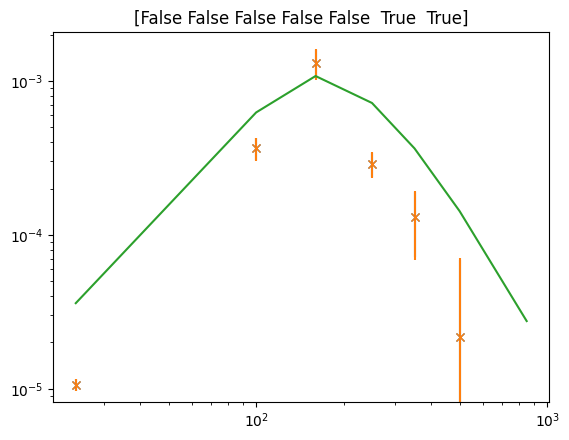

In [167]:
plt.figure()
plt.title(results['nd'][key_to_fit])
plt.errorbar(results['wvs'], results['seds'][key_to_fit], yerr=results['stds'][key_to_fit], fmt='x')
plt.errorbar(results['wvs'], results['seds'][key_to_fit], yerr=np.sqrt(np.diag(results['cov'][key_to_fit])), fmt='x')
plt.plot(results['wvs'], graybody_fn(theta0, results['wvs'])[0])

plt.loglog()
plt.show()
plt.close()

In [168]:
nsteps = 10000
sampler.run_mcmc(initial, nsteps, progress=True)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_83079/2077004924.py:47: RuntimeWarning: divide by zero encountered in log
  ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
  0%|          | 0/10000 [00:00<?, ?it/s]/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:22<00:00, 444.68it/s]


State([[-35.1920691   22.94218682   2.63238254   1.67991981]
 [-34.8605298   22.02748904   2.61427753   1.65900981]
 [-35.4140107   22.84694547   2.61394535   1.70198249]
 [-36.54848256  21.17654409   2.44780867   1.8012316 ]
 [-35.17194121  22.92693562   2.61909828   1.68105743]
 [-34.8622626   22.49026258   2.53387189   1.65320095]
 [-37.90376897  20.15909958   2.36675593   1.91779728]
 [-33.09113469  25.42812075   2.69014614   1.49004033]
 [-34.62453039  25.37965695   2.81886358   1.61375952]
 [-34.43572808  23.77549238   2.74199096   1.61010392]
 [-36.63727799  23.17725965   2.59853475   1.78735158]
 [-37.00360518  24.69496212   2.87695873   1.81359969]
 [-33.06269783  23.865903     2.68003355   1.50396953]
 [-37.17012649  21.93422252   2.65451491   1.85059883]
 [-33.30711199  22.48343492   2.51827755   1.52907791]
 [-33.55710926  22.80608701   2.56086061   1.54871071]
 [-35.9672003   22.98244517   2.61402847   1.73738391]
 [-34.72721188  25.15455426   2.76288909   1.62107976]
 [-3

-35.25663870286972 22.928998930422736
2.597465066639609 1.6812745790649621


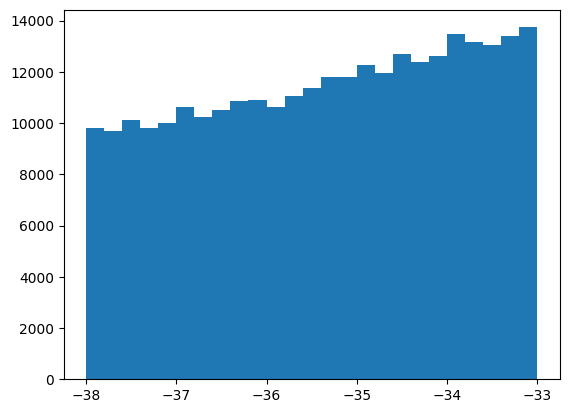

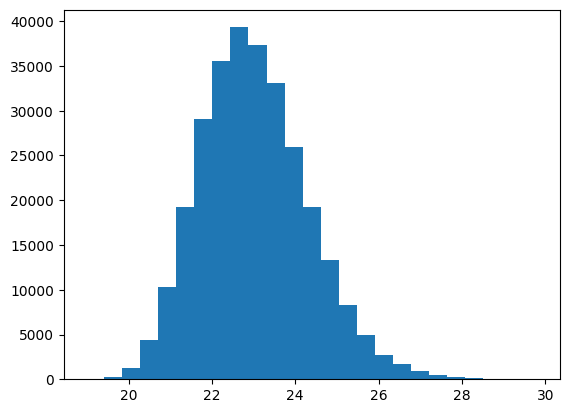

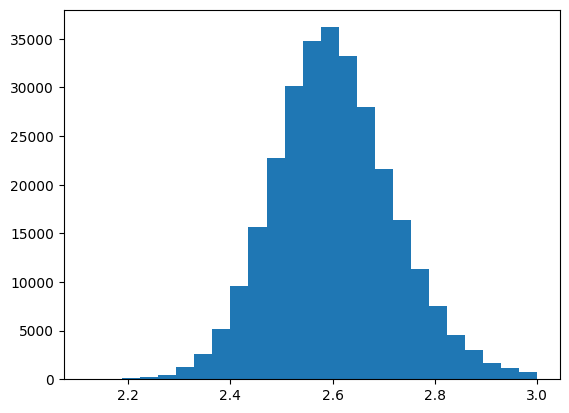

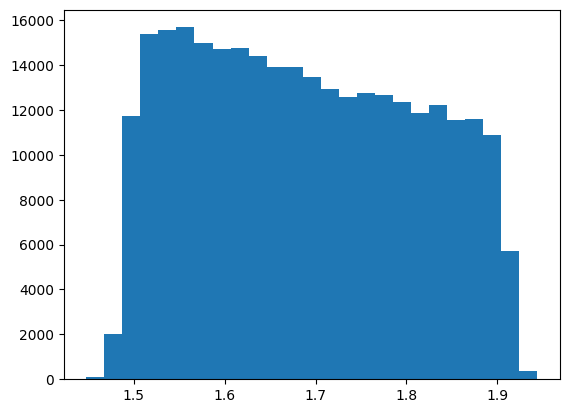

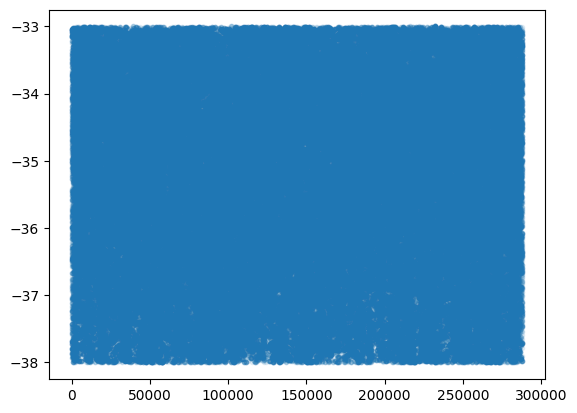

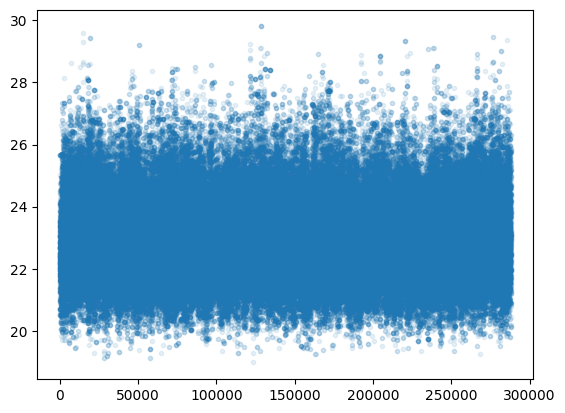

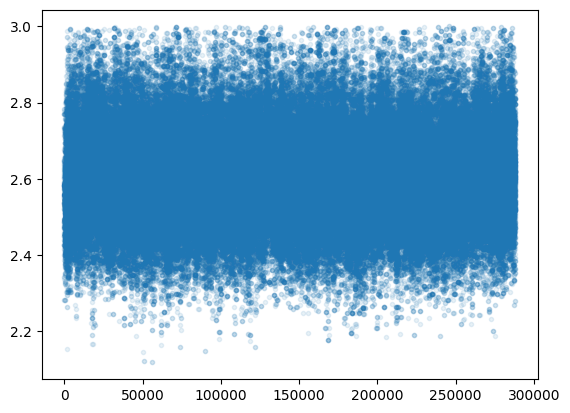

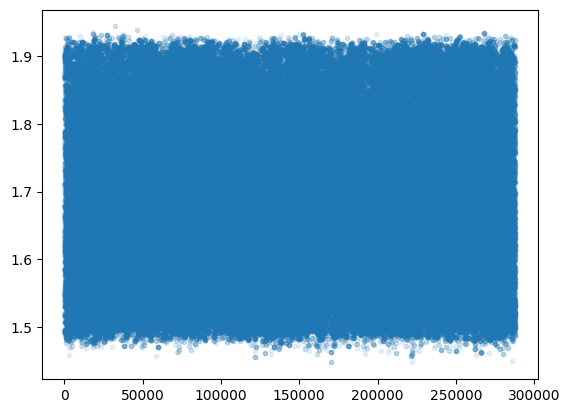

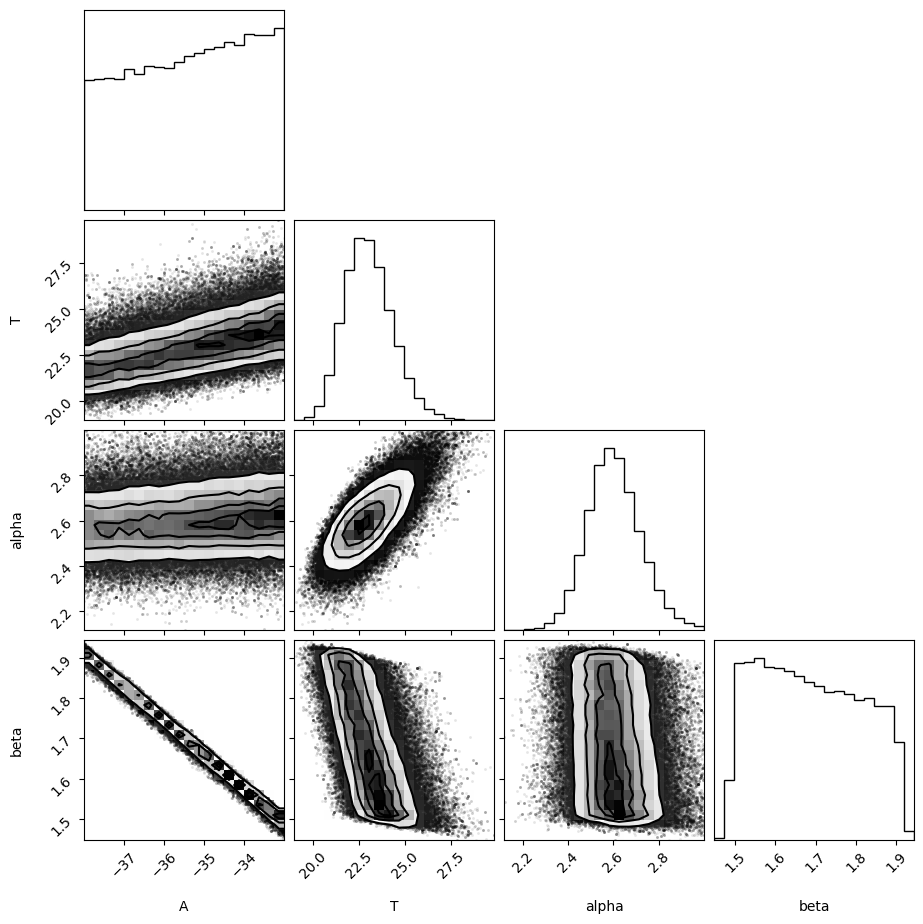

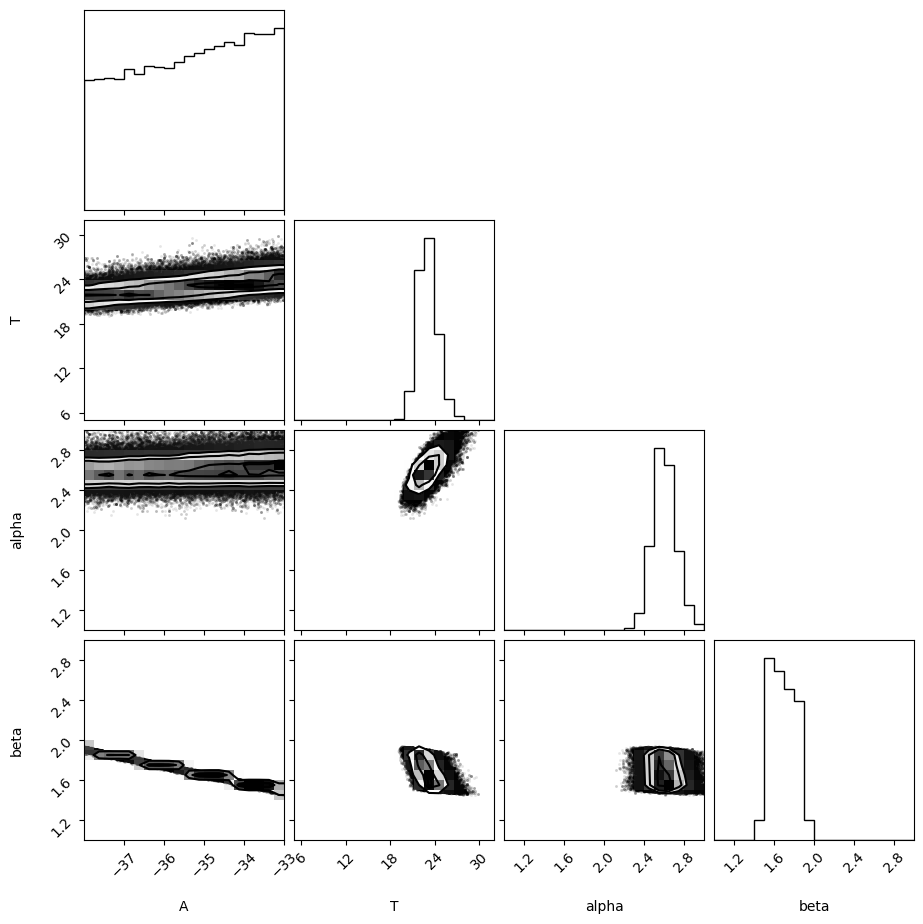

In [169]:
samples = sampler.get_chain(discard=1000, flat=True)
As, Ts = samples[:,0], samples[:,1]
Abest, Tbest = np.median(As), np.median(Ts)
print(Abest, Tbest)
if FIT_MORE:
    alps, bets = samples[:,2], samples[:,3]
    alp_best, bet_best = np.median(alps), np.median(bets)
    print(alp_best, bet_best)

if FIT_MORE:
    print_arr = [As, Ts, alps, bets]
else:
    print_arr = [As, Ts]

for val in print_arr:
    plt.figure()
    plt.hist(val, bins=25)
    plt.show()
    plt.close()

for i in range(ndim):    
    plt.figure()
    plt.plot(samples[:, i], alpha=0.1, marker='.', ls="none")
    plt.show()
    plt.close()

if FIT_MORE:
    corner.corner(samples, labels=['A', 'T', 'alpha', 'beta'])
else:
    corner.corner(samples, labels=['A', 'T'])
    
if FIT_MORE:
    corner.corner(samples, labels=['A', 'T', 'alpha', 'beta'], range=[(-38, -33), (5, 32), (1, 3), (1, 3)])
else:
    corner.corner(samples, labels=['A', 'T'], range=[(-38, -33), (5, 32)])

plt.show()
plt.close()


In [170]:
wvs = results['wvs']
if FIT_MORE:
    C_best = graybody_fn((Abest, Tbest, alp_best, bet_best), wvs)[0]
else:
    C_best = graybody_fn((Abest, Tbest), wvs)[0]

C_samples = np.array([graybody_fn(val, wvs)[0] for val in samples])
C_std = np.std(C_samples, axis=0)

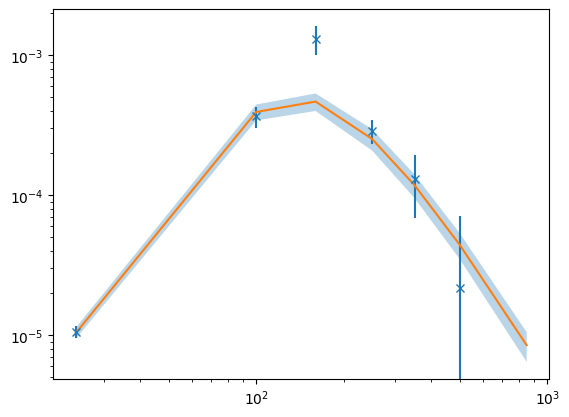

In [171]:
plt.figure()
plt.errorbar(wvs, y, yerr=np.sqrt(np.diag(yerr)), fmt='x')
plt.plot(wvs, C_best)
plt.fill_between(wvs, C_best - C_std, C_best + C_std, alpha=0.3)
plt.loglog()
plt.show()
plt.close()

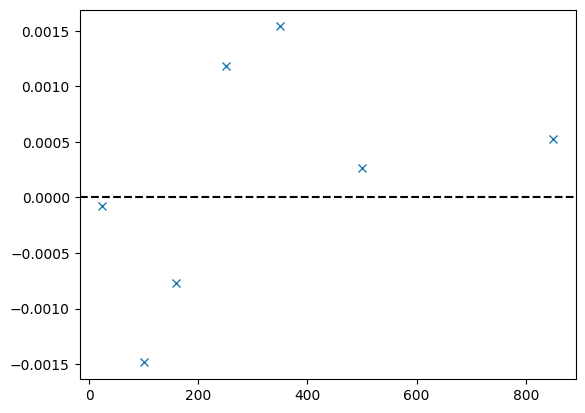

In [37]:
# plot residuals 
plt.figure()
plt.errorbar(wvs, y - C_best, fmt='x')
plt.axhline(0, color='k', ls='--')
plt.show()
plt.close()

In [22]:
CII_wav = 157.74 # microns
zs = np.array(wvs) / CII_wav - 1
wvs, zs

([24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0],
 array([-0.84785089, -0.36604539,  0.01432737,  0.58488652,  1.21884113,
         2.16977304,  4.38861418]))

In [23]:
results['z_med']

{'z=0.01_0.33__logM=3_8__SF?=0': 0.1065,
 'z=0.01_0.33__logM=3_8__SF?=1': 0.1629,
 'z=0.01_0.33__logM=8_9__SF?=0': 0.2318,
 'z=0.01_0.33__logM=8_9__SF?=1': 0.2608,
 'z=0.01_0.33__logM=9_10__SF?=0': 0.26254999999999995,
 'z=0.01_0.33__logM=9_10__SF?=1': 0.2603,
 'z=0.01_0.33__logM=10_13__SF?=0': 0.27164999999999995,
 'z=0.01_0.33__logM=10_13__SF?=1': 0.2663,
 'z=0.33_0.86__logM=3_8__SF?=0': 0.43074999999999997,
 'z=0.33_0.86__logM=3_8__SF?=1': 0.531,
 'z=0.33_0.86__logM=8_9__SF?=0': 0.5968,
 'z=0.33_0.86__logM=8_9__SF?=1': 0.6571,
 'z=0.33_0.86__logM=9_10__SF?=0': 0.64285,
 'z=0.33_0.86__logM=9_10__SF?=1': 0.663,
 'z=0.33_0.86__logM=10_13__SF?=0': 0.6819,
 'z=0.33_0.86__logM=10_13__SF?=1': 0.6929,
 'z=0.86_1.6__logM=3_8__SF?=0': 0.98325,
 'z=0.86_1.6__logM=3_8__SF?=1': 1.077,
 'z=0.86_1.6__logM=8_9__SF?=0': 0.9618,
 'z=0.86_1.6__logM=8_9__SF?=1': 1.1876,
 'z=0.86_1.6__logM=9_10__SF?=0': 1.0586,
 'z=0.86_1.6__logM=9_10__SF?=1': 1.2369,
 'z=0.86_1.6__logM=10_13__SF?=0': 1.1443,
 'z=0.86_1

Let's look at the "z=1.0_1.5" bin with z = 1.21884113 possibility in the 350 $\mu\text{m}$ map

In [45]:
special_wv_index = 5
map_wv = results['wvs'][special_wv_index]
map_z = zs[special_wv_index]
zbin_used = "z=1.6_2.9"

print(map_wv, map_z, zbin_used)

z_ran = zbin_used.split("_")[0].split("=")[1], zbin_used.split("_")[1]
assert(float(z_ran[0]) <= map_z < float(z_ran[1]))

500.0 2.1697730442500314 z=1.6_2.9


In [47]:
# Viero+22 uses their informative prior in these bins
# informative_prior = ['z=1.5_2.0__logM=9.5_10.0__SF?=1',
#                     'z=2.0_2.5__logM=9.5_10.0__SF?=1',
#                     'z=2.0_2.5__logM=10.0_10.5__SF?=1',
#                     'z=3.0_3.5__logM=9.5_10.0__SF?=1',
#                     'z=3.5_4.0__logM=10.0_10.5__SF?=1',
#                     'z=5.0_6.0__logM=9.5_10.0__SF?=1',
#                     'z=6.0_8.0__logM=10.5_11.0__SF?=1',
#                     'z=6.0_8.0__logM=11.0_12.0__SF?=1']

In [48]:
results['z_med']

{'z=0.01_0.33__logM=3_8__SF?=0': 0.1065,
 'z=0.01_0.33__logM=3_8__SF?=1': 0.1629,
 'z=0.01_0.33__logM=8_9__SF?=0': 0.2318,
 'z=0.01_0.33__logM=8_9__SF?=1': 0.2608,
 'z=0.01_0.33__logM=9_10__SF?=0': 0.26254999999999995,
 'z=0.01_0.33__logM=9_10__SF?=1': 0.2603,
 'z=0.01_0.33__logM=10_13__SF?=0': 0.27164999999999995,
 'z=0.01_0.33__logM=10_13__SF?=1': 0.2663,
 'z=0.33_0.86__logM=3_8__SF?=0': 0.43074999999999997,
 'z=0.33_0.86__logM=3_8__SF?=1': 0.531,
 'z=0.33_0.86__logM=8_9__SF?=0': 0.5968,
 'z=0.33_0.86__logM=8_9__SF?=1': 0.6571,
 'z=0.33_0.86__logM=9_10__SF?=0': 0.64285,
 'z=0.33_0.86__logM=9_10__SF?=1': 0.663,
 'z=0.33_0.86__logM=10_13__SF?=0': 0.6819,
 'z=0.33_0.86__logM=10_13__SF?=1': 0.6929,
 'z=0.86_1.6__logM=3_8__SF?=0': 0.98325,
 'z=0.86_1.6__logM=3_8__SF?=1': 1.077,
 'z=0.86_1.6__logM=8_9__SF?=0': 0.9618,
 'z=0.86_1.6__logM=8_9__SF?=1': 1.1876,
 'z=0.86_1.6__logM=9_10__SF?=0': 1.0586,
 'z=0.86_1.6__logM=9_10__SF?=1': 1.2369,
 'z=0.86_1.6__logM=10_13__SF?=0': 1.1443,
 'z=0.86_1

24 z=1.6_2.9__logM=3_8__SF?=0 30 1.8075
mips penalty: 1
use informative prior: False
theta0: -39.749761500000005 12.213828138913625 34.2903225 None


100%|██████████| 15000/15000 [00:04<00:00, 3644.22it/s]


best: -39.72937589698603 12.249857552877387 34.39147507970326
best: 2.0168053051907147 1.794419278434889


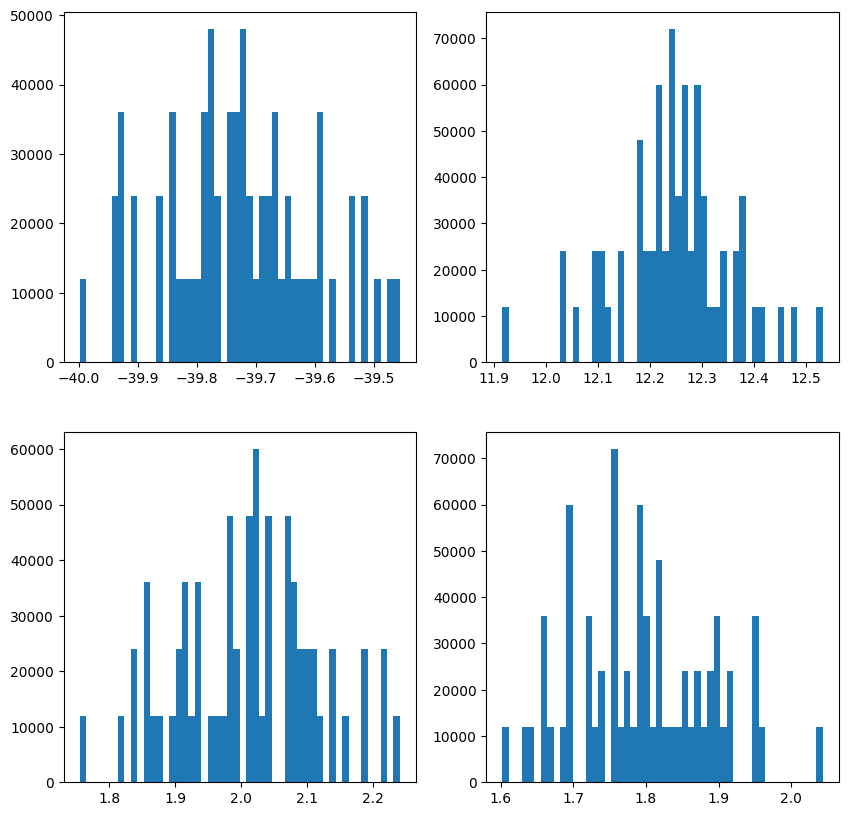

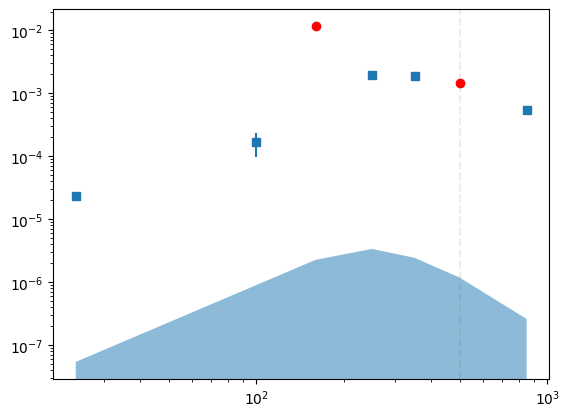

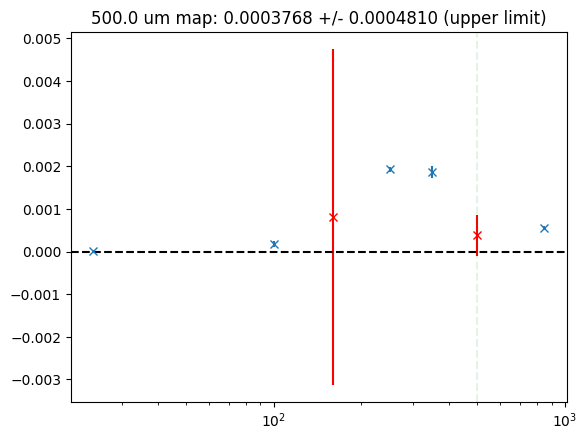

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_73374/2096970624.py:27: RuntimeWarning: invalid value encountered in log
  + len(dy) * np.log(2 * np.pi) + np.log(np.linalg.det(yerr_d)))


25 z=1.6_2.9__logM=3_8__SF?=1 7025 1.9202
too few detections
26 z=1.6_2.9__logM=8_9__SF?=0 29 1.7221
mips penalty: 1
use informative prior: False
theta0: -37.338587000000004 12.37075469821094 33.674431364 None


  0%|          | 0/15000 [00:00<?, ?it/s]/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_73374/2096970624.py:30: RuntimeWarning: divide by zero encountered in log
  ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
100%|██████████| 15000/15000 [01:23<00:00, 178.96it/s]


best: -37.34079690140666 12.371223975179248 33.675708782835436
best: 2.031222865456259 1.8050233436501224


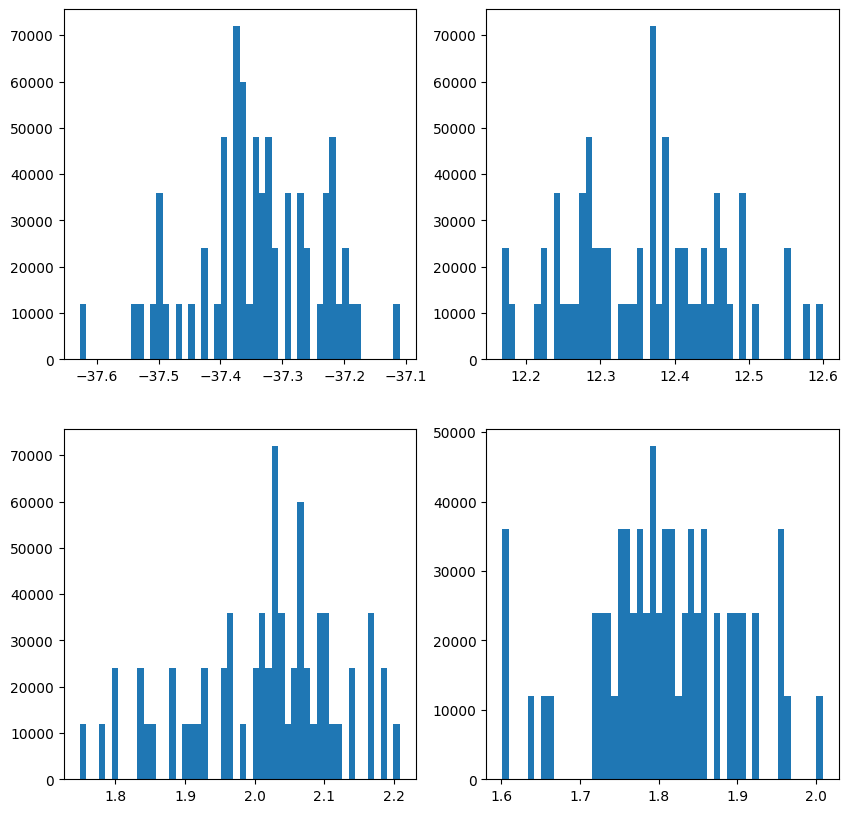

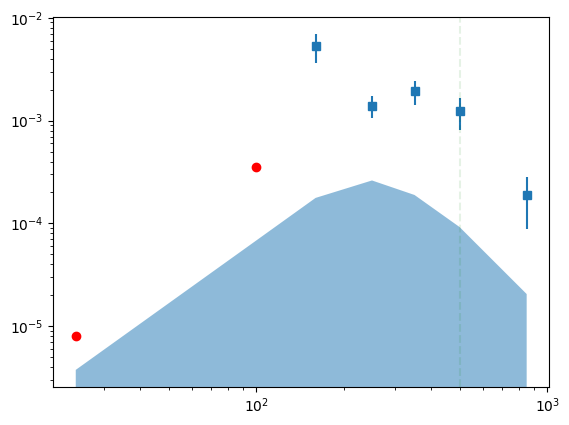

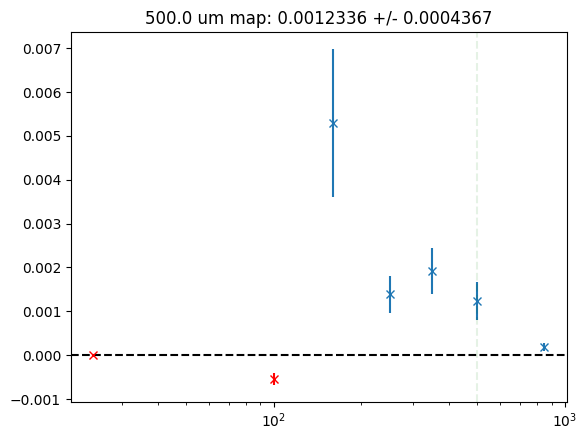

27 z=1.6_2.9__logM=8_9__SF?=1 62482 2.119
too few detections
28 z=1.6_2.9__logM=9_10__SF?=0 319 1.8833
mips penalty: 1
use informative prior: False
theta0: -36.358594 12.084024401206952 34.841867556000004 None


100%|██████████| 15000/15000 [01:24<00:00, 177.16it/s]


best: -36.38406023069006 12.12110067812128 34.94876958522709
best: 2.025920442801853 1.8098628783379418


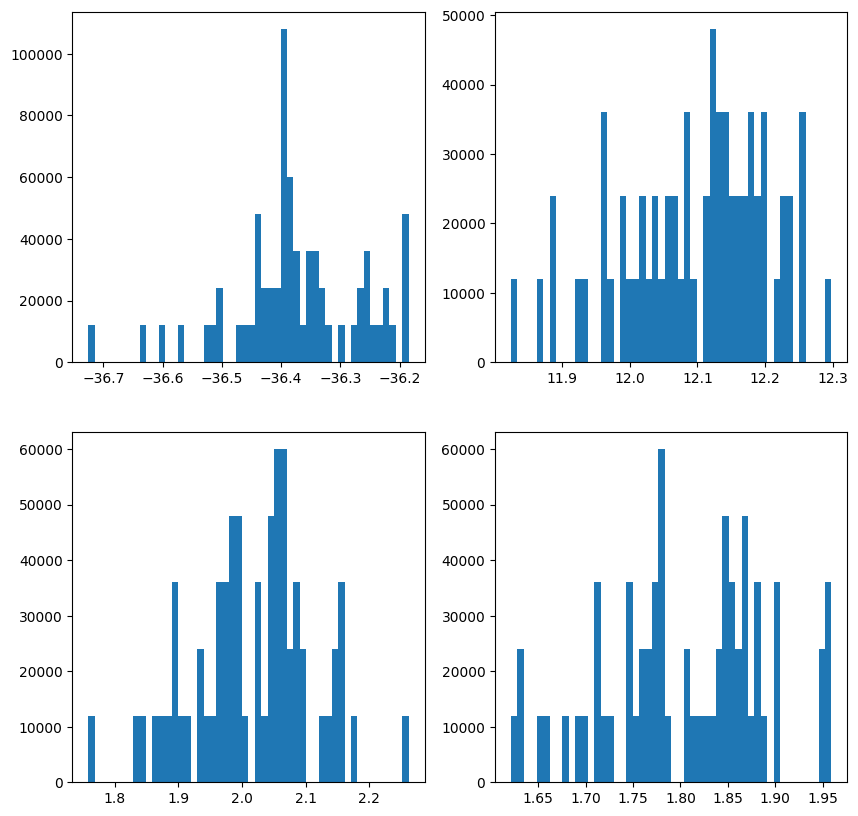

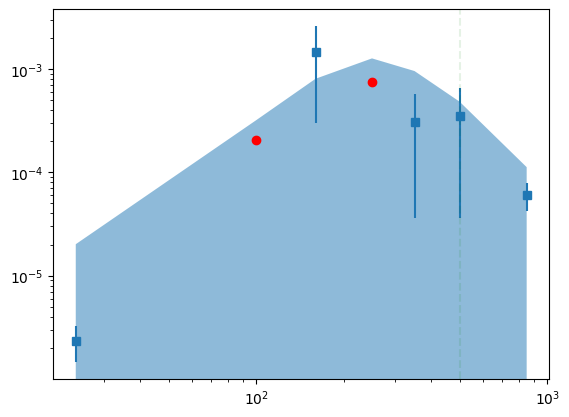

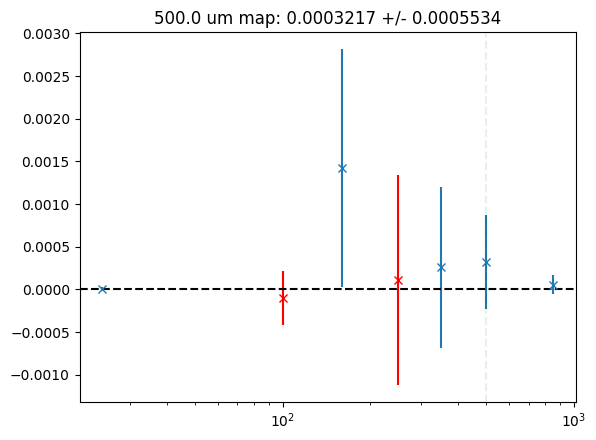

29 z=1.6_2.9__logM=9_10__SF?=1 60455 2.2309
mips penalty: 1
use informative prior: False
theta0: -36.812245000000004 11.585002916834318 37.429985924 None


100%|██████████| 15000/15000 [01:24<00:00, 176.47it/s]


best: -36.80554207500778 11.57909535845241 37.41089919362389
best: 1.9982495076154332 1.8045825240529685


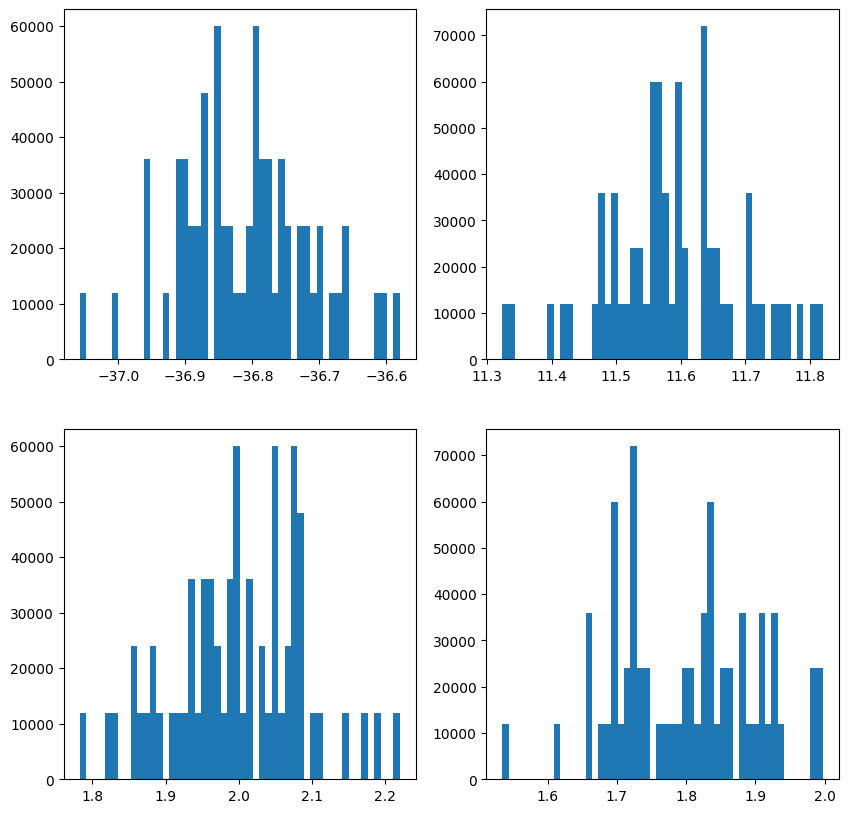

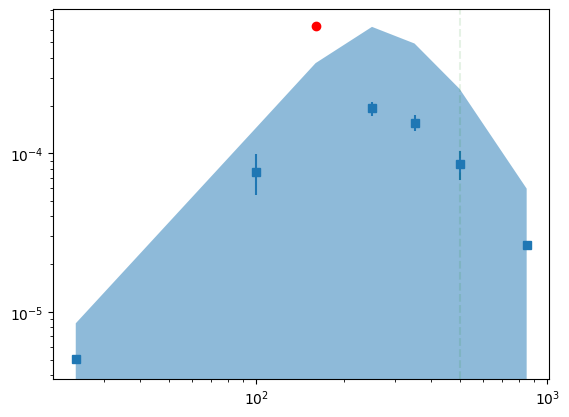

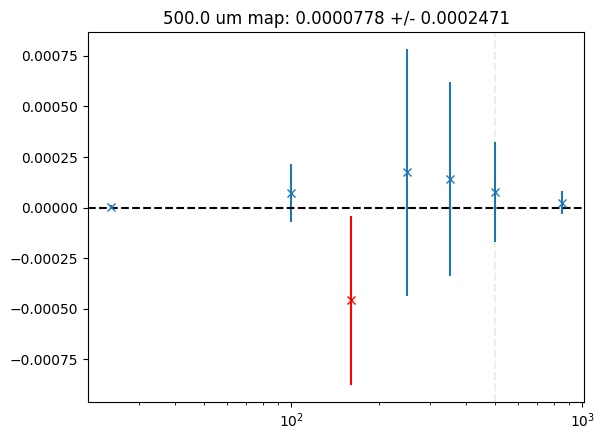

30 z=1.6_2.9__logM=10_13__SF?=0 2868 1.95255
mips penalty: 4
use informative prior: False
theta0: -35.437638500000006 11.972623867843051 35.349770601 None


 74%|███████▍  | 11145/15000 [00:51<00:18, 210.47it/s]Traceback (most recent call last):
  File "/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_73374/2096970624.py", line 44, in log_probability
    return lp + log_likelihood(theta, x, y, yerr, nd)
  File "/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_73374/2096970624.py", line 30, in log_likelihood
    ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
  File "/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2313, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 88, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
KeyboardInterrup

emcee: Exception while calling your likelihood function:
  params: [-33.           5.           2.80827188   1.74839795]
  args: (array([ 24., 100., 160., 250., 350., 500., 850.]), array([1.21412400e-05, 3.78576650e-06, 1.72395436e-03, 1.60133516e-04,
       3.78712448e-04, 5.62130826e-04, 9.16915836e-05]), array([[ 2.11554370e-11,  1.64428689e-09,  1.12647155e-11,
         1.00196900e-10,  4.13990705e-11, -3.60852239e-11,
         2.56869567e-11],
       [ 1.64428689e-09,  1.45605791e-07,  6.93301059e-08,
         8.27718496e-09,  6.85460551e-09,  3.15621065e-09,
        -4.47165700e-10],
       [ 1.12647155e-11,  6.93301059e-08,  2.63190516e-07,
         1.93520960e-09,  1.40046902e-08,  2.28984239e-08,
        -9.38136676e-09],
       [ 1.00196900e-10,  8.27718496e-09,  1.93520960e-09,
         4.88010924e-10,  2.96055894e-10, -7.03893911e-12,
         5.44814828e-11],
       [ 4.13990705e-11,  6.85460551e-09,  1.40046902e-08,
         2.96055894e-10,  8.23893389e-10,  1.14696873e-0

KeyboardInterrupt: 

In [50]:
# loop over emcee code above for keys with "z=1.0_1.5"

emcee_results = {}

for ind, bkey in enumerate(bkeys):
    if zbin_used not in bkey:
        continue
    if "__SF?=1" not in bkey:
        continue
    print(ind, bkey, results['ngals'][bkey], results['z_med'][bkey])

    x = np.array(results['wvs'])
    y = np.array(results['seds'][bkey])
    nd = np.array(results['nd'][bkey])
    z_median = results['z_med'][bkey]
    m_median = results['m_med'][bkey]
    
    if np.sum(nd) > 3:
        print("too few detections")
        continue
    
    # implement MIPS penalty as in Viero+22
    if (z_median > 1.5) & (z_median < 2) & (m_median >= 10):
        mips_penalty = 4
    elif (z_median > 2.0) & (z_median < 2.5) & (m_median >= 10):
        mips_penalty = 2.5
    elif (z_median > 1.5) & (z_median < 2.5):
        mips_penalty = 1
    elif (z_median > 0.5) & (z_median < 3):
        mips_penalty = 2
    else:
        mips_penalty = 1
    print("mips penalty:", mips_penalty)
    yboot = results['boot'][bkey].copy()
    yboot[:, 0] *= mips_penalty
    yerr = np.cov(yboot, rowvar=False)
    
    # use_informative_prior = bkey in informative_prior
    use_informative_prior = False
    print("use informative prior:", use_informative_prior)
    
    Tmodel = (22.5 + 5.8 * z_median + 0.4 * z_median ** 2) / (1 + z_median)
    Amodel = -47 - z_median*0.05 + 11 * (m_median / 10)
    sigma_T = 0.25 if use_informative_prior else None
    print("theta0:", Amodel, Tmodel, Tmodel * (1 + z_median), sigma_T)
    
    pertubation = 1e-1
    # theta0 = (Amodel, Tmodel) if not use_informative_prior else (Amodel, Tmodel, sigma_T)
    theta0 = (Amodel, Tmodel, 2.0, 1.8) if not use_informative_prior else (Amodel, Tmodel, 2.0, 1.8, sigma_T)
    ndim, nwalkers = 4, 64
    # ndim, nwalkers = 2, 64
    initial = theta0[:ndim] + pertubation * np.random.randn(nwalkers, ndim)
    
    args = (x, y, yerr, nd) if not use_informative_prior else (x, y, yerr, nd, theta0)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    nsteps, burn_in = 5000, 3000
    sampler.run_mcmc(initial, nsteps, progress=True)
    
    samples = sampler.get_chain(discard=burn_in, flat=True)
    As, Ts = samples[:, 0], samples[:, 1]
    alps, bets = samples[:, 2], samples[:, 3]
    Abest, Tbest = np.median(As), np.median(Ts)
    alp_best, bet_best = np.median(alps), np.median(bets)
    print("best:", Abest, Tbest, Tbest * (1 + z_median))
    print("best:", alp_best, bet_best)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i, val in enumerate([As, Ts, alps, bets]):
        ax = axs.flatten()[i]
        ax.hist(val, bins=50)
    plt.show()
    plt.close()
    
    # C_best = graybody_fn((Abest, Tbest), x)[0]
    C_best = graybody_fn((Abest, Tbest, alp_best, bet_best), x)[0]
    C_samples = np.array([graybody_fn(val, x)[0] for val in samples])
    C_std = np.std(C_samples, axis=0)
    
    plt.figure()
    plt.fill_between(x, C_best - C_std, C_best + C_std, alpha=0.5)
    plt.errorbar(x[~nd], y[~nd], yerr=np.sqrt(np.diag(yerr))[~nd], fmt='s')
    plt.scatter(x[nd], np.sqrt(np.diag(yerr))[nd] * 3.0, c='r', marker='o')
    plt.axvline(x[special_wv_index], color='g', ls='--', alpha=0.1)
    plt.loglog()
    plt.show()
    plt.close()
    
    residuals = y - C_best
    sig_residuals = np.sqrt(np.diag(yerr) + C_std ** 2)
    
    plt.figure()
    if not nd[special_wv_index]:
        plt.title(f"{wvs[special_wv_index]} um map: {residuals[special_wv_index]:.7f} +/- {sig_residuals[special_wv_index]:.7f}")
    else:
        plt.title(f"{wvs[special_wv_index]} um map: {residuals[special_wv_index]:.7f} +/- {sig_residuals[special_wv_index]:.7f} (upper limit)")
    plt.errorbar(x[~nd], residuals[~nd], yerr=sig_residuals[~nd], fmt='x')
    plt.errorbar(x[nd], residuals[nd], yerr=sig_residuals[nd], fmt='x', color='r')
    plt.axhline(0, color='k', ls='--')
    plt.axvline(x[special_wv_index], color='g', ls='--', alpha=0.1)
    plt.xscale('log')
    plt.show()
    plt.close()
    
    emcee_results[bkey] = (Abest, Tbest, C_best, C_std, samples, residuals, sig_residuals, nd)
    
emcee_results

In [32]:
# add measurements from all bins
res = np.array([emcee_results[bkey][5][special_wv_index] for bkey in emcee_results.keys()])
sig_res = np.array([emcee_results[bkey][6][special_wv_index] for bkey in emcee_results.keys()])

# weighted by the inverse variance
weights = 1 / sig_res ** 2
total_res = np.sum(res * weights) / np.sum(weights)
total_sig_res = 1 / np.sqrt(np.sum(weights))
total_res, total_sig_res, total_res / total_sig_res

(-0.00019091104612306664, 1.345320048088497e-05, -14.190753077256472)

note that above is a naive addition, probably want to weigh this by n_gal

In [33]:
total_sig_res / results['beams'][special_wv_index] * 3.0 # 3 sigma limit in Jy/sr?

1082.02684832855

In [34]:
# add measurements from all bins, weighted by the number of galaxies
res = np.array([emcee_results[bkey][5][special_wv_index] for bkey in emcee_results.keys()])
sig_res = np.array([emcee_results[bkey][6][special_wv_index] for bkey in emcee_results.keys()])
ngals = np.array([results['ngals'][bkey] for bkey in emcee_results.keys()])

# weighted by the inverse variance
total_res_per_bin = res * ngals
total_sig_res_per_bin = sig_res * ngals
weights = 1 / total_sig_res_per_bin ** 2
total_res = np.sum(total_res_per_bin * weights) / np.sum(weights)
total_sig_res = 1 / np.sqrt(np.sum(weights))
total_res, total_sig_res, total_res / total_sig_res

(-1.9313935067209562, 0.33600690003441397, -5.748076919025002)

In [35]:
total_sig_res / (1.6 * u.deg**2).to(u.sr).value * 3.0 # 3 sigma limit in Jy/sr? 

2068.210472026379

In [36]:
total_res / (1.6 * u.deg**2).to(u.sr).value, total_sig_res / (1.6 * u.deg**2).to(u.sr).value

(-3962.744292646878, 689.4034906754597)

In [86]:
wvs

[24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0]

In [101]:
zmins_used = []
for bkey in bkeys:
    zmin, zmax = bkey.split("__")[0].split("=")[1].split("_")
    if zmin not in zmins_used:
        print(zmin, zmax)
        print(157.7 * (1 + float(zmin)), 157.7 * (1 + float(zmax)))
        zmins_used += [zmin]

0.01 0.5
159.277 236.54999999999998
0.5 1.0
236.54999999999998 315.4
1.0 1.5
315.4 394.25
1.5 2.0
394.25 473.09999999999997
2.0 2.5
473.09999999999997 551.9499999999999
2.5 3.0
551.9499999999999 630.8
3.0 3.5
630.8 709.65
3.5 4.0
709.65 788.5
4.0 5.0
788.5 946.1999999999999
5.0 6.0
946.1999999999999 1103.8999999999999
6.0 8.0
1103.8999999999999 1419.3
8.0 10.0
1419.3 1734.6999999999998
